In [4]:
import pandas as pd

df = pd.read_csv('creditcard.csv')

In [5]:
# 1. Standardize rain/test split (80/20, stratified)

from sklearn.model_selection import train_test_split

X, y = df.drop(columns=['Class']), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")

X_train shape: (227845, 30) | X_test shape: (56962, 30)
y_train shape: (227845,) | y_test shape: (56962,)


In [6]:
# Standardize 'Time' and 'Amount' features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Learn mean/std ONLY from training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Apply training statistics

## Logistic Regression

In [7]:
# 2. Train a Logistic Regression with class_weight='balanced'

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
# 3. Evaluate: precision, recall, F1 for the fraud class

from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Get fraud probabilities
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"y_pred shape: {y_pred.shape} | y_test shape: {y_test.shape}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

y_pred shape: (56962,) | y_test shape: (56962,)
Precision: 0.06097560975609756
Recall: 0.9183673469387755
F1 Score: 0.11435832274459974


In [9]:
# 4. Print a classification report

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



Fraud probability stats:
Min: 0.003571323568337392, Max: 1.0, Mean: 0.916947743701986

Non-fraud probability stats:
Min: 3.709210014743477e-31, Max: 1.0, Mean: 0.073829685053746


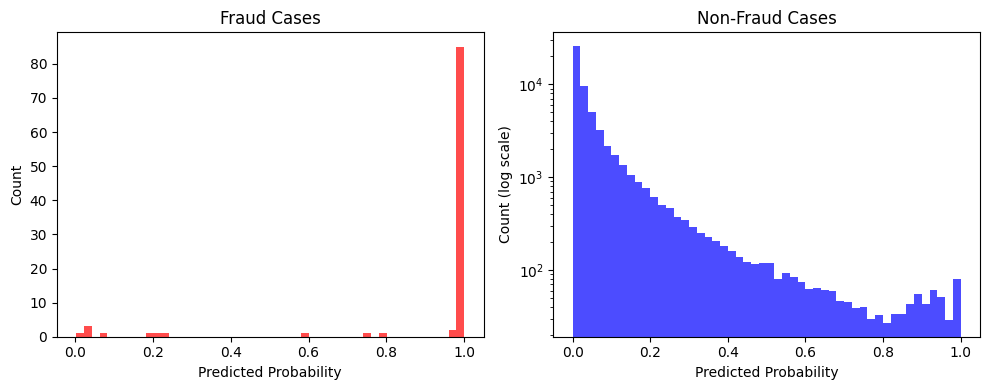

In [10]:
import matplotlib.pyplot as plt

# Look at fraud probabilities separately
fraud_probs = y_pred_proba[y_test == 1]
non_fraud_probs = y_pred_proba[y_test == 0]

print(f"Fraud probability stats:")
print(f"Min: {fraud_probs.min()}, Max: {fraud_probs.max()}, Mean: {fraud_probs.mean()}")
print(f"\nNon-fraud probability stats:")
print(f"Min: {non_fraud_probs.min()}, Max: {non_fraud_probs.max()}, Mean: {non_fraud_probs.mean()}")

# Show distributions on log scale to see both
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(fraud_probs, bins=50, alpha=0.7, color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Fraud Cases')

plt.subplot(1, 2, 2)
plt.hist(non_fraud_probs, bins=50, alpha=0.7, color='blue')
plt.xlabel('Predicted Probability')
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.title('Non-Fraud Cases')
plt.tight_layout()
plt.show()

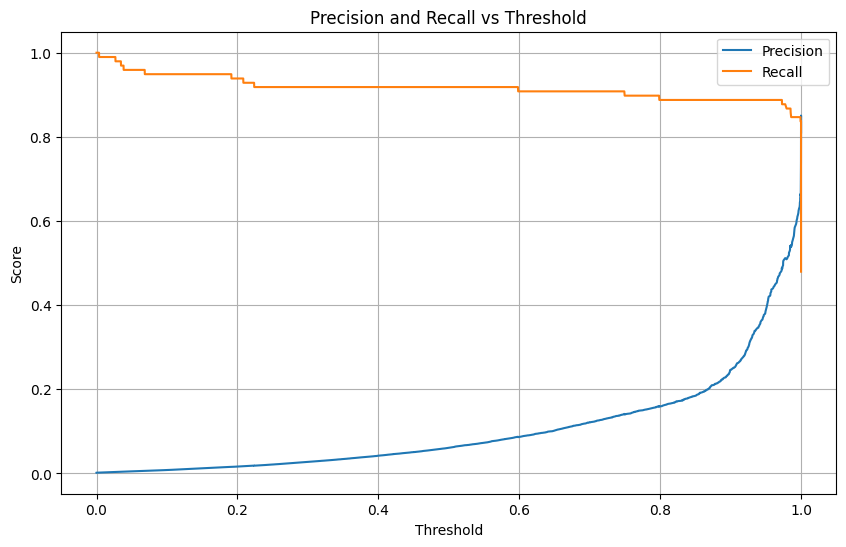

In [11]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision vs recall at different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# Sample fewer thresholds (e.g., 100 evenly spaced from 0 to 1)
threshold_samples = np.linspace(0, 1, 100)

f1_scores = []
for threshold in threshold_samples:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = threshold_samples[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.4f}")
print(f"Best F1 score: {best_f1:.4f}")

y_pred_best = (y_pred_proba >= best_threshold).astype(int)
print("\nClassification report at best threshold:")
print(classification_report(y_test, y_pred_best))

# **Note: sklearn contribution idea**

# Build `sklearn.metrics.find_optimal_threshold(y_true, y_scores, metric='f1')` 
# returns optimal threshold and metric value for a given scoring function. 
# Could support f1, precision, recall, or custom scorers. 
# Check existing sklearn issues/PRs first to avoid duplicate work.
# Could also weigh precision/recall 

Best threshold: 0.9899
Best F1 score: 0.6803

Classification report at best threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.85      0.68        98

    accuracy                           1.00     56962
   macro avg       0.78      0.92      0.84     56962
weighted avg       1.00      1.00      1.00     56962



## Ensemble Models

In [16]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Random Forest with class weight
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=100
)

# XGBoost with scale_pos_weight
# scale_pos_weight should be (# non-fraud / # fraud)
scale_pos_weight = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100
)

In [17]:
# Train both models

rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [19]:
# Random Forest
print("Random Forest Model: \n")

# 3. Evaluate: precision, recall, F1 for the fraud class

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # Get fraud probabilities
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"y_pred shape: {y_pred_rf.shape} | y_test shape: {y_test.shape}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

# 4. Print a classification report

report = classification_report(y_test, y_pred_rf)
print(report)


# XGBoost
print("XGBoost model: \n")

# 3. Evaluate: precision, recall, F1 for the fraud class

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Get fraud probabilities
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"y_pred shape: {y_pred_xgb.shape} | y_test shape: {y_test.shape}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")

# 4. Print a classification report

report = classification_report(y_test, y_pred_xgb)
print(report)

Random Forest Model: 

y_pred shape: (56962,) | y_test shape: (56962,)
Precision: 0.9605263157894737
Recall: 0.7448979591836735
F1 Score: 0.8390804597701149
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost model: 

y_pred shape: (56962,) | y_test shape: (56962,)
Precision: 0.8817204301075269
Recall: 0.8367346938775511
F1 Score: 0.8586387434554974
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



Random Forest - Fraud Probability Analysis:
Fraud probability stats:
Min: 0.0, Max: 1.0, Mean: 0.7051020408163264

Non-fraud probability stats:
Min: 0.0, Max: 0.99, Mean: 0.0004192459200900395


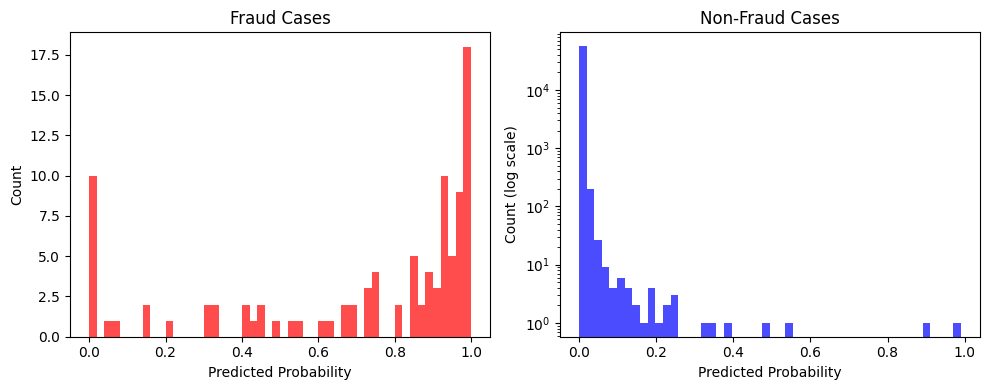

XGBoost - Fraud Probability Analysis:
Fraud probability stats:
Min: 2.0999465277782292e-07, Max: 1.0, Mean: 0.8422400951385498

Non-fraud probability stats:
Min: 4.27193791452396e-09, Max: 0.9977189898490906, Mean: 0.0002721679338719696


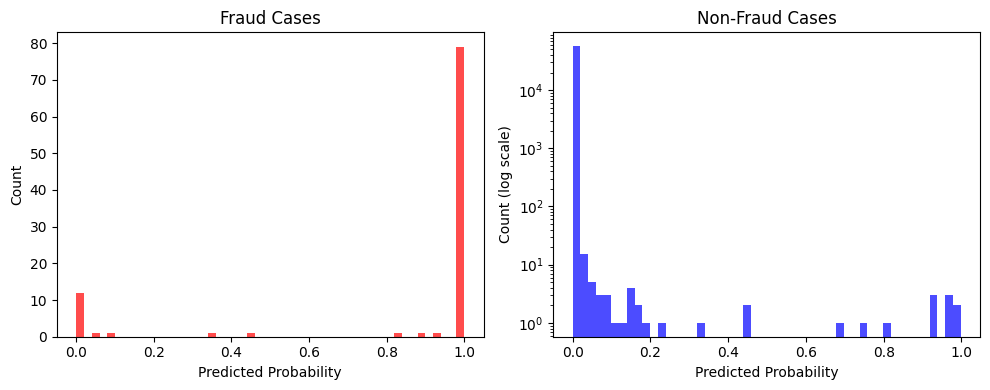

In [24]:
def plot_fraud_probabilities(y_test, y_pred_proba, model_name="Model"):
    
    print(f"{model_name} - Fraud Probability Analysis:")
    # Look at fraud probabilities separately
    fraud_probs = y_pred_proba[y_test == 1]
    non_fraud_probs = y_pred_proba[y_test == 0]

    print(f"Fraud probability stats:")
    print(f"Min: {fraud_probs.min()}, Max: {fraud_probs.max()}, Mean: {fraud_probs.mean()}")
    print(f"\nNon-fraud probability stats:")
    print(f"Min: {non_fraud_probs.min()}, Max: {non_fraud_probs.max()}, Mean: {non_fraud_probs.mean()}")

    # Show distributions on log scale to see both
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(fraud_probs, bins=50, alpha=0.7, color='red')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Fraud Cases')

    plt.subplot(1, 2, 2)
    plt.hist(non_fraud_probs, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count (log scale)')
    plt.yscale('log')
    plt.title('Non-Fraud Cases')
    plt.tight_layout()
    plt.show()
    
plot_fraud_probabilities(y_test, y_pred_proba_rf, "Random Forest")
plot_fraud_probabilities(y_test, y_pred_proba_xgb, "XGBoost")

Random Forest - Precision and Recall vs Threshold:


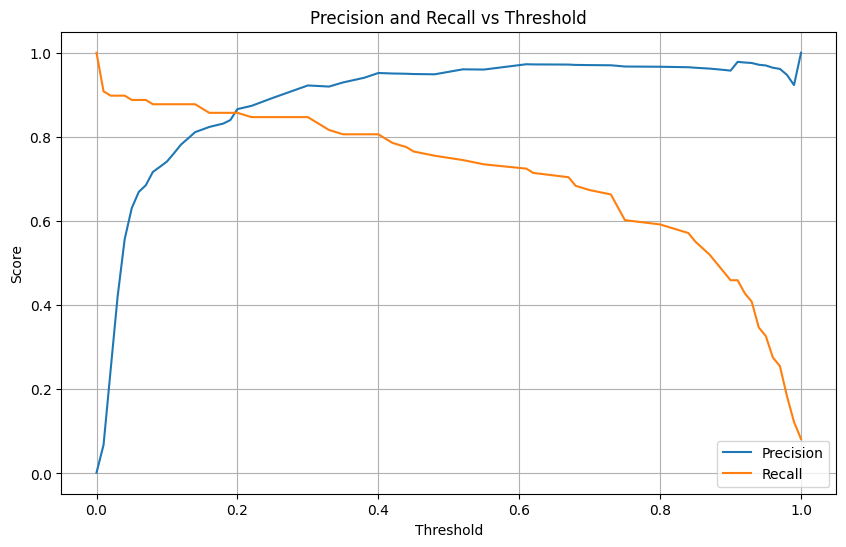

XGBoost - Precision and Recall vs Threshold:


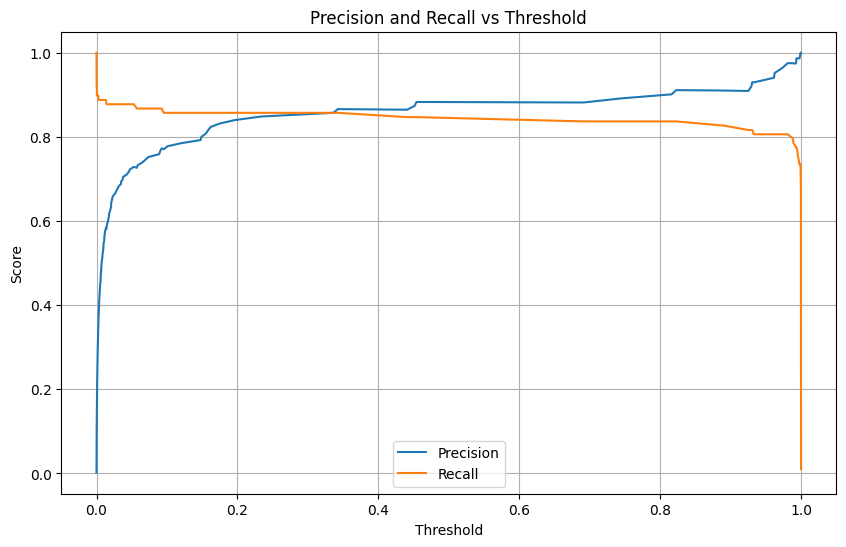

In [25]:
def plot_precision_recall_vs_threshold(y_test, y_pred_proba, model_name="Model"):

    print(f"{model_name} - Precision and Recall vs Threshold:")
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Plot precision vs recall at different thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Precision and Recall vs Threshold')
    plt.grid(True)
    plt.show()

plot_precision_recall_vs_threshold(y_test, y_pred_proba_rf, "Random Forest")
plot_precision_recall_vs_threshold(y_test, y_pred_proba_xgb, "XGBoost")

In [26]:
def find_best_threshold(y_test, y_pred_proba, model_name="Model"):

    print(f"{model_name} - Finding Best Threshold based on F1 Score:")
    # Sample fewer thresholds (e.g., 100 evenly spaced from 0 to 1)
    threshold_samples = np.linspace(0, 1, 100)

    f1_scores = []
    for threshold in threshold_samples:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_threshold)
        f1_scores.append(f1)

    best_idx = np.argmax(f1_scores)
    best_threshold = threshold_samples[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Best threshold: {best_threshold:.4f}")
    print(f"Best F1 score: {best_f1:.4f}")

    y_pred_best = (y_pred_proba >= best_threshold).astype(int)
    print("\nClassification report at best threshold:")
    print(classification_report(y_test, y_pred_best))
    
    
find_best_threshold(y_test, y_pred_proba_rf, "Random Forest")
find_best_threshold(y_test, y_pred_proba_xgb, "XGBoost")

Random Forest - Finding Best Threshold based on F1 Score:
Best threshold: 0.2525
Best F1 score: 0.8830

Classification report at best threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.85      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost - Finding Best Threshold based on F1 Score:
Best threshold: 0.9798
Best F1 score: 0.8827

Classification report at best threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.98      0.81      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



### We go with Random Forest at 0.25 threshold for its flexibility and higher recall